# CycleGAN - Horse2Zebra

---

In this notebook will learn about Generative Adversarial Networks by implementing a Cycle GAN to transfer styles from Horse to Zebra.

**Important:** Set the Cloab environment to run on GPU

Author: Ramon Planas

Based on SIMPLE GAN colab from: Albert Pumarola

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import os
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from PIL import Image
import numpy as np
import math

## Utils
Some utils with minor importance

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1  or classname.find('ConvTranspose2d') != -1 or classname.find('Linear') != -1:
        m.weight.data.normal_(0.00, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [3]:
# Download horse2zebra
!mkdir -p ./datasets
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./datasets/horse2zebra.zip

# Unzip dataset
!unzip ./datasets/horse2zebra.zip -d ./datasets/

for details.

--2020-03-11 12:06:04--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  20.9MB/s    in 6.1s    

2020-03-11 12:06:11 (18.4 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/h

**Generate Dataset class**

In [0]:
class Horse2ZebraDataset(Dataset):
  """
  Dataset class to load images
  """
  def __init__(self, root_dir, transform=None):
    """
    Args:
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
        on a sample.
    """
    self.root_dir = root_dir
    self.transform = transform
    self.list_images = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.list_images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.list_images[idx])
    image = Image.open(img_name)

    if self.transform:
      image = self.transform(image)

    return image

class TwoDatasets(Dataset):
  """
  Dataset class to get samples from two different image collections
  """
  def __init__(self, root_dirA, root_dirB, batch_size, transform= None):
    self.root_dirA = root_dirA
    self.root_dirB = root_dirB
    self.filelistA = os.listdir(self.root_dirA)
    self.filelistB = os.listdir(self.root_dirB)
    self.transform=transform
    self.batch_size = batch_size

  def __len__(self):
    if len(self.filelistA) < len(self.filelistB):
      num_img = int(len(self.filelistA)/self.batch_size) * self.batch_size
    else:
      num_img = int(len(self.filelistB)/self.batch_size) * self.batch_size
    return num_img

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_nameA = os.path.join(self.root_dirA, self.filelistA[idx])
    img_nameB = os.path.join(self.root_dirB, self.filelistB[idx])

    imageA = Image.open(img_nameA).convert('RGB')
    imageB = Image.open(img_nameB).convert('RGB')

    if self.transform:
      imageA = self.transform(imageA)
      imageB = self.transform(imageB)

    return imageA, imageB


In [0]:
image_size = 128
batch_size = 9
tf = transforms.Compose(
    [transforms.Resize(image_size, interpolation=0),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

#horse2zebra_trainA = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/trainA', transform=tf)
#horse2zebra_testA  = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/testA', transform=tf)

#horse2zebra_trainB = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/trainB', transform=tf)
#horse2zebra_testB  = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/testB', transform=tf)

horse2zebra_train = TwoDatasets('./datasets/horse2zebra/trainA', './datasets/horse2zebra/trainB', batch_size, transform=tf)
horse2zebra_test  = TwoDatasets('./datasets/horse2zebra/testA',  './datasets/horse2zebra/testB',  batch_size, transform=tf)

## Data Loader
Create data loaders for the horse2zebra dataset

In [0]:
#data_loader_trainA = torch.utils.data.DataLoader(horse2zebra_trainA, batch_size=batch_size, shuffle=True)
#data_loader_testA  = torch.utils.data.DataLoader(horse2zebra_testA,  batch_size=batch_size, shuffle=True)
#data_loader_trainB = torch.utils.data.DataLoader(horse2zebra_trainB, batch_size=batch_size, shuffle=True)
#data_loader_testB  = torch.utils.data.DataLoader(horse2zebra_testB,  batch_size=batch_size, shuffle=True)

data_loader_train = torch.utils.data.DataLoader(horse2zebra_train, batch_size=batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(horse2zebra_test,  batch_size=batch_size, shuffle=True)


Show some examples

1062
117


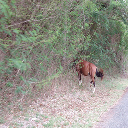

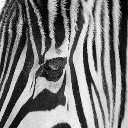

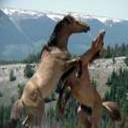

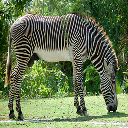

In [43]:
print(len(horse2zebra_train))
print(len(horse2zebra_test))

display_batch_images(horse2zebra_train[0][0])
display_batch_images(horse2zebra_train[0][1])
#
display_batch_images(horse2zebra_test[0][0])
display_batch_images(horse2zebra_test[0][1])

## Networks
First, lets define our simple generator

In [0]:
class Generator_simple(torch.nn.Module):
    
    def __init__(self):
        super(Generator_simple, self).__init__()
      
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc1 = nn.Linear(512*8*8, 512)
        self._fc2 = nn.Linear(512, 512*8*8)

        self._deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self._deconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        # Image to image
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)

        x = self._fc1(x.view(-1, 512*8*8))
        x = self._fc2(x)

        x = self._deconv1(x.view(x.shape[0], 512, 8, 8))
        x = self._deconv2(x)
        out = self._deconv3(x)

        return out

Generator from Cycle GAN paper

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # ENCODING
        self._encoder1 = self.encoder(3, 64, 4)
        self._encoder2 = self.encoder(64, 128, 4)
        self._encoder3 = self.encoder(128, 256, 4)

        # TRANSFORMATION (RESNET)
        self._res1 = self.residual(256, 256, 3)
        self._res2 = self.residual(256, 256, 3)
        self._res3 = self.residual(256, 256, 3)

        # DECODING
        self._decoder1 = self.decoder(256, 128, 4)
        self._decoder2 = self.decoder(128, 64, 4)
        self._decoder3 = self.decoder2(64, 3, 4)

    def encoder(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2)
        )
        return x

    def residual(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2),
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2)
        )
        return x

    def decoder(self, i, o, dim):
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.ReLU()
        )
        return x

    def decoder2(self, i, o, dim): #Same as previous without normalization and changing Relu by Tanh
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        return x 

    def forward(self, x):
        # Encode -> Transform -> Decode
        # Encoding
        x = self._encoder1(x)
        x = self._encoder2(x)
        x = self._encoder3(x)

        # Transformation: Resnet blocks
        a = self._res1(x)
        b = x + a
        c = self._res2(b)
        d = b + c
        e = self._res3(d)
        x = d + e

        # Decoding
        x = self._decoder1(x)
        x = self._decoder2(x)
        x = self._decoder3(x)

        return x

Similarly lets define a simple discriminator

In [0]:
class Discriminator_simple(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator_simple, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*8*8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        out = self._fc(x.view(-1, 512*8*8))

        return out

Discriminator from Cycle GAN paper

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(int(512*image_size*image_size/(8*8)), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        output = self._fc(x.view(-1, int(512*image_size*image_size/(8*8))))

        return output

## Model
Now lets create the core of our task, the model.  Remember Cycle GANs loss:
$\mathcal{L}_{GAN}(G,D_Y,X,Y)=\mathbb{E}_{y\sim p_{data}(y)}\big[logD_Y(y)\big] + \mathbb{E}_{x\sim p_{data}(x)}\big[log(1-D_Y(G(x)))\big]$

$\mathcal{L}_{cyc}(G,F)=\mathbb{E}_{x\sim p_{data}(x)}\big[||F(G(x))-x||_1\big] + \mathbb{E}_{y\sim p_{data}(y)}\big[||G(F(y))-y||_1\big]$

The full objective is:

$\mathcal{L}(G,F,D_X,D_Y)=\mathcal{L}_{GAN}(G,D_Y,X,Y) + \mathcal{L}_{GAN}(F,D_X,Y,X) + \lambda\mathcal{L}_{cyc}(G,F)$

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizers()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generatorA2B = Generator()
        self._generatorB2A = Generator()
        self._discriminatorA = Discriminator()
        self._discriminatorB = Discriminator()

        # init weights
        self._generatorA2B.apply(init_weights)
        self._generatorB2A.apply(init_weights)
        self._discriminatorA.apply(init_weights)
        self._discriminatorB.apply(init_weights)

        # move to cuda
        self._generatorA2B.cuda()
        self._generatorB2A.cuda()
        self._discriminatorA.cuda()
        self._discriminatorB.cuda()
        
    def _create_optimizers(self):
        # generators optimizers
        self._opt_genA2B = torch.optim.Adam(self._generatorA2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_genB2A = torch.optim.Adam(self._generatorB2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminators optimizers
        self._opt_discrA = torch.optim.Adam(self._discriminatorA.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_discrB = torch.optim.Adam(self._discriminatorB.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterionGAN = nn.MSELoss()# To fight vanisshing gradients better MSELoss than BCELoss
        self._criterionCYC = nn.L1Loss()# L1 for Cycle Consistency Loss
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samplesA, real_samplesB, lambda_cyc):

        # Reset gradients
        self._opt_genA2B.zero_grad()
        self._opt_genB2A.zero_grad()
        self._opt_discrA.zero_grad()
        self._opt_discrB.zero_grad()

        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)

        cyc_samplesA = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB = self._generatorA2B(fake_samplesB2A)

        #
        # optimize generator A2B & B2A
        #
        # discriminators are not updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = False
        for params in self._discriminatorB.parameters():
          params.requires_grad = False

        estim_fakeA = self._discriminatorB(fake_samplesA2B)
        loss_gA = self._criterionGAN(estim_fakeA, self._label_real)
        estim_fakeB = self._discriminatorA(fake_samplesB2A)
        loss_gB = self._criterionGAN(estim_fakeB, self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA)
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB)
        loss_cyc = loss_cycA + loss_cycB
        #
        loss_gA2B = loss_gA + lambda_cyc*loss_cyc
        loss_gB2A = loss_gB + lambda_cyc*loss_cyc
        #
        loss_gA2B.backward(retain_graph=True)
        loss_gB2A.backward()
        self._opt_genA2B.step()
        self._opt_genB2A.step()

        #
        # optimize discriminator A
        #
        for params in self._discriminatorA.parameters():
          params.requires_grad = True

        # Calculate discriminator A loss for real samples A
        estim_realA = self._discriminatorA(real_samplesA)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)

        # Calculate discriminator A loss for fake samples B2A
        estim_fakeA = self._discriminatorA(fake_samplesB2A.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)

        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        self._opt_discrA.step()
        
        #
        # optimize discriminator B
        #
        for params in self._discriminatorB.parameters():
          params.requires_grad = True

        # Calculate discriminator B loss for real samples B
        estim_realB = self._discriminatorB(real_samplesB)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)

        # Calculate discriminator B loss for fake samples A2B
        estim_fakeB = self._discriminatorB(fake_samplesA2B.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)

        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()
        self._opt_discrB.step()

        return loss_gA2B.item(), loss_gB2A.item(), loss_dA.item(), loss_dB.item(), loss_cyc.item()
             

## Train

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_epochs = 200
lambda_cyc = 10
model = Model(batch_size)

print(f"Number of parameters GeneratorA2B: {count_parameters(model._generatorA2B)}")
print(f"Number of parameters GeneratorB2A: {count_parameters(model._generatorB2A)}")
print(f"Number of parameters DiscriminatorA: {count_parameters(model._discriminatorA)}")
print(f"Number of parameters DiscriminatorB: {count_parameters(model._discriminatorB)}")


Number of parameters GeneratorA2B: 4860160
Number of parameters GeneratorB2A: 4860160
Number of parameters DiscriminatorA: 2760321
Number of parameters DiscriminatorB: 2760321


In [46]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samplesA, real_samplesB) in enumerate(data_loader_train):

        # Prepare batch data
        real_samplesA = Variable(real_samplesA).cuda()
        real_samplesB = Variable(real_samplesB).cuda()

        # Update model weights
        loss_gA2B, loss_gB2A, loss_dA, loss_dB, loss_cyc = model.step_optimization(real_samplesA, real_samplesB, lambda_cyc)
        
        # Adaptive lambda_cyc
        if loss_cyc > 0.50:
          lambda_cyc = 10
        elif loss_cyc < 0.50 and loss_cyc > 0.25:
          lambda_cyc = 5
        elif loss_cyc < 0.25:
          lambda_cyc = 1

        # Show fake samples
        if n_batch == 10 and (epoch) % 10 == 0:
            fake_samplesA = model._generatorA2B(real_samplesA)
            fake_samplesB = model._generatorB2A(fake_samplesA)
            display_batch_images(real_samplesA)
            display_batch_images(fake_samplesA.detach())
            display_batch_images(fake_samplesB.detach())
            #
            fake_samplesB = model._generatorB2A(real_samplesB)
            fake_samplesA = model._generatorA2B(fake_samplesB)
            display_batch_images(real_samplesB)
            display_batch_images(fake_samplesB.detach())
            display_batch_images(fake_samplesA.detach())

    # Show current loss
    #if (n_batch) % 100 == 0:
    print(f"epoch: {epoch+1}/{num_epochs}, batch: {n_batch+1}/{len(data_loader_train)}, GA2B_loss: {loss_gA2B}, GB2A_loss: {loss_gB2A}")
    print(f"                             DA_loss: {loss_dA}, DB_loss: {loss_dB}, CYC_loss: {loss_cyc}")    
          


Output hidden; open in https://colab.research.google.com to view.

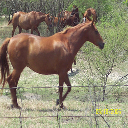

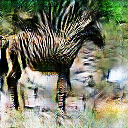

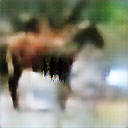

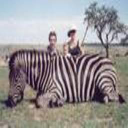

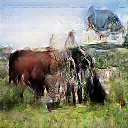

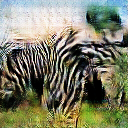

In [0]:
# Test example - 100 epochs - lambda = 1
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


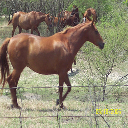

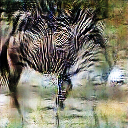

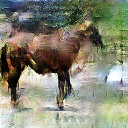

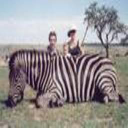

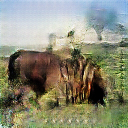

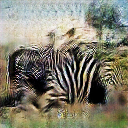

In [0]:
# Test example - 100 epochs - lambda = 2
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


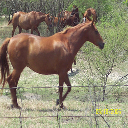

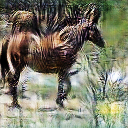

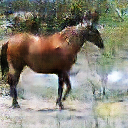

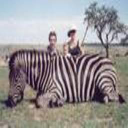

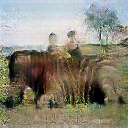

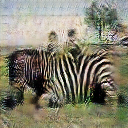

In [0]:
# Test example - 100 epochs - lambda = 5
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


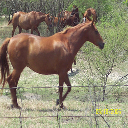

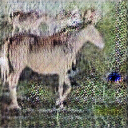

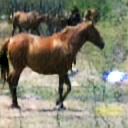

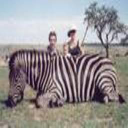

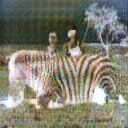

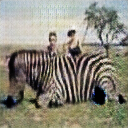

In [0]:
# Test example - 100 epochs - lambda = 10
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())


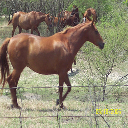

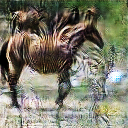

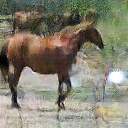

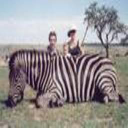

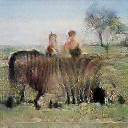

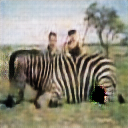

In [0]:
# Test example - 200 epochs - lambda adaptive
idx = 9
fake_samplesA = model._generatorA2B(horse2zebra_test[idx][0].unsqueeze(0).cuda())
fake_samplesB = model._generatorB2A(fake_samplesA)
display_batch_images(horse2zebra_test[idx][0])
display_batch_images(fake_samplesA.detach())
display_batch_images(fake_samplesB.detach())
#
fake_samplesB = model._generatorB2A(horse2zebra_test[idx][1].unsqueeze(0).cuda())
fake_samplesA = model._generatorA2B(fake_samplesB)
display_batch_images(horse2zebra_test[idx][1])
display_batch_images(fake_samplesB.detach())
display_batch_images(fake_samplesA.detach())
